In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import re
import math
import os, sys
import numpy as np
from functools import partial
import argparse

import tensorflow as tf
from tensorpack.dataflow.common import BatchData, MapData
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.applications.vgg19 import VGG19
from keras.layers import Input, Lambda, LSTM, Reshape, TimeDistributed, Dense
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard
from keras.utils import multi_gpu_model as multigpu

# from components import *
sys.path.append('/scratch/ua349/pose/tf/ver1')
from training.train_pose import *
from training.optimizers import MultiSGD
from training.dataset import get_dataflow

In [19]:
weight_decay = 5e-4
BSIZE = 16

base_lr = 4e-5 # 2e-5
momentum = 0.9
lr_policy =  "step"
gamma = 0.333

TIME_STEPS = 1

stages = 6
np_branch1 = 38
np_branch2 = 19

IMSIZE = 368
OUTSIZE = 46

In [20]:
from components import *

img_input_shape = (TIME_STEPS, IMSIZE, IMSIZE, 3)
vec_input_shape = (TIME_STEPS, None, None, 38)
heat_input_shape = (TIME_STEPS, None, None, 19)

inputs = []
outputs = []

img_input = Input(shape=img_input_shape)
vec_weight_input = Input(shape=vec_input_shape)
heat_weight_input = Input(shape=heat_input_shape)

inputs.append(img_input)
inputs.append(vec_weight_input)
inputs.append(heat_weight_input)

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input) # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized, weight_decay)

# stage 1 - branch 1 (PAF)
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1, weight_decay)
w1 = apply_mask(stage1_branch1_out, vec_weight_input, heat_weight_input, np_branch1, 1, 1)

# stage 1 - branch 2 (confidence maps)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2, weight_decay)
w2 = apply_mask(stage1_branch2_out, vec_weight_input, heat_weight_input, np_branch2, 1, 2)

x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

print('Concat shape:', x.get_shape())
outputs.append(w1)
outputs.append(w2)

# stage sn >= 2
for sn in range(2, stages + 1):
    # stage SN - branch 1 (PAF)
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1, weight_decay)
    w1 = apply_mask(stageT_branch1_out, vec_weight_input, heat_weight_input, np_branch1, sn, 1)

    # stage SN - branch 2 (confidence maps)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2, weight_decay)
    w2 = apply_mask(stageT_branch2_out, vec_weight_input, heat_weight_input, np_branch2, sn, 2)

    outputs.append(w1)
    outputs.append(w2)

    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])
        
print('Final shapes:', stageT_branch2_out.get_shape())

Concat shape: (?, 1, 46, 46, 185)
Final shapes: (?, 1, 46, 46, 19)


In [22]:
model = Model(inputs=inputs, outputs=outputs)

In [26]:
def restore_weights(weights_best_file, model):
    # load previous weights or vgg19 if this is the first run
    if os.path.exists(weights_best_file):
        print("Loading the best weights...")

        model.load_weights(weights_best_file)

#         return get_last_epoch() + 1
    else:
        raise Exception('File not found!')

In [49]:
# restore_weights('/scratch/ua349/pose/tf/ver1/model/keras/model.h5', model)
restore_weights('../tf/ver1/training/checkpoints/epoch_2.h5', model)


Loading the best weights...


(674, 712, 3)


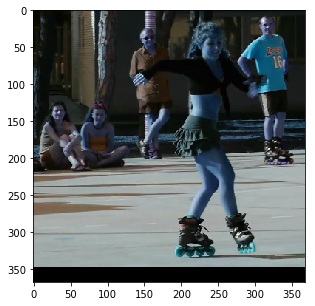

In [50]:
import cv2
from cv2 import imread
import matplotlib.pyplot as plt
sample = cv2.imread('ski.jpg')
print(sample.shape)
canvas = np.zeros((368, 368, 3))
sample = cv2.resize(sample, (0,0), fx=368/712, fy=368/712)
canvas[:sample.shape[0], :sample.shape[1]] = sample

plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
plt.imshow(canvas/256)
plt.show()

In [53]:
results = model.predict([
    canvas.reshape((1, 1, 368, 368, 3)), 
    np.ones((1, 1, 46, 46, 38)), 
    np.ones((1, 1, 46, 46, 19))])
print(len(results))

12


-0.028972741 1.0010284


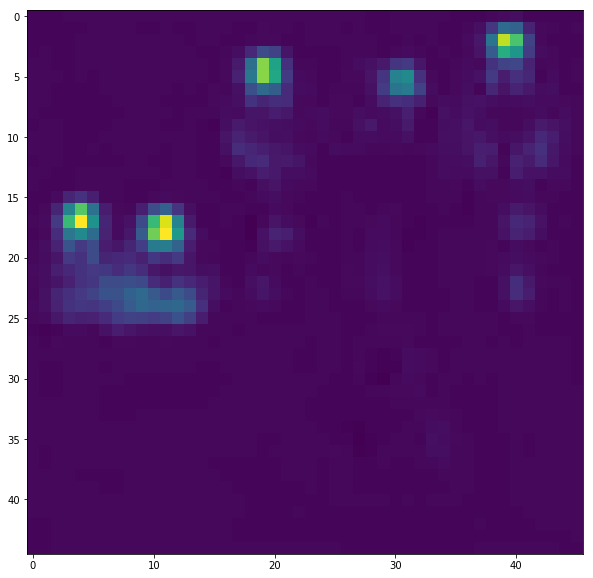

In [54]:
print(np.min(results[-1]), np.max(results[-1]))

plt.figure(figsize=(14, 10))
flat = np.sum(np.squeeze(results[-1])[:-1], axis=-1)
plt.imshow(flat)
plt.show()